In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

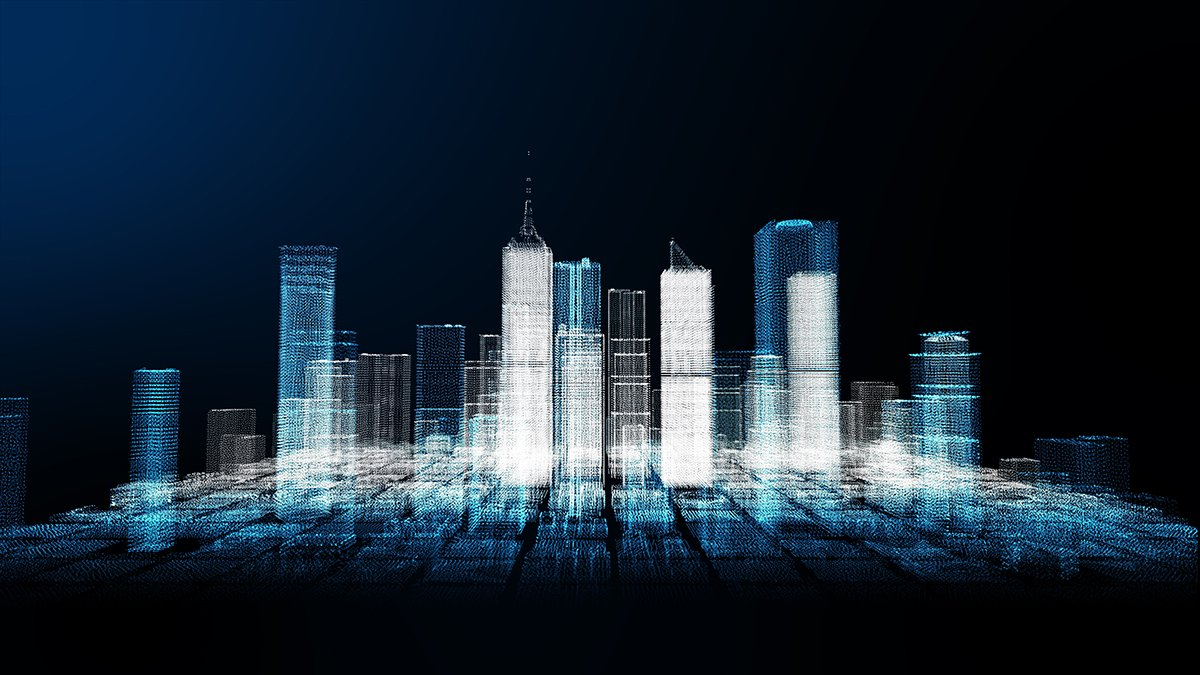

# ASHRAE - Great Energy Predictor III

  **How much energy will a building consume?**

- <a href='#1'>1. Introduction</a>
    - <a href='#1-1'>1.1. Data</a>
    - <a href='#1-2'>1.2. Evaluation Metric</a>
      
- <a href='#2'>2. Exploratory Data Analysis</a>
   - <a href='#2-1'>2.1. Analysis of train dataset</a>
   - <a href='#2-2'>2.2. Analysis of weather dataset</a>
   - <a href='#2-3'>2.3. Analysis of building dataset</a>
   - <a href='#2-4'>2.4. More exploration</a>
       - <a href='#2-4.1'>2.4.1 Expand Timestamp</a>
       - <a href='#2-4.2'>2.4.2 Exploration with time</a>
    
- <a href='#3'>3. Missing Data</a>
- <a href='#4'>4. Outliers</a>
- <a href='#5'>5. Models</a>



In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
import gc


# <a id='1'>1. Introduction</a>

In this competition, we are tasked with developing accurate predictions of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.

The aim is that with better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

## <a id='1-1'>1.1 Data</a>

- We are trying to predict energy consuption for 1449 buildings. The value we are trying to predict is the `meter_reading`
- Each building can have multiple meters - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
- We are given:
    1. Historic meter reading data by timestamp for the building (`train.csv`)
    2. Building metadata including the building use, square ft area, year build(`building_meta.csv`). This data does not change between the training and test set.
    3. Weather data with predicpitation, cloud_coverage, `air_temperature` and more (`weather_[train/test].csv`)
- We are also provied csvs to be used for submission:
    1. `test.csv` which contains the meter, building id and timestamp we will be predicting for
    2. `sample_submission.csv` which contains all the future data we would like to predict



## <a id='1-2'>1.2 Evaluation Metric</a>


The evaluation metric for this competition is Root Mean Squared Logarithmic Error.
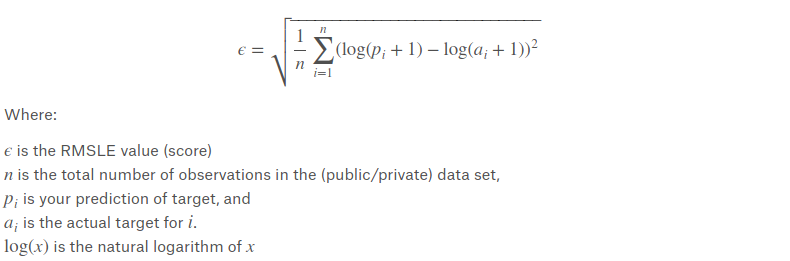

# <a id='2'>2. Exploratory Data Analysis</a>

##  <a id='2-1'>2.1. Analysis of train dataset</a>

In [ ]:
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
print(train["timestamp"].min() , train["timestamp"].max(),sep ="\n")


In [ ]:
train['meter_reading'].describe()

In [ ]:
zeros = train[train['meter_reading']== 0].shape[0] / train.shape[0]
print('Zero reading percentile : {}'.format(round(zeros,3)))

9% of the reading value is zero.We have the information that some buildings have more than one meter type and we can consider as usage of seasonal energy meters may cause zeros.To be more spesific,we don't need to use chilled water at cold days.Likewise,hotwater usage can be change time to time.However,those data can be missing because no energy consumption doesn't make sense at all !

In [ ]:
# Converting meter to what they stand for

train['meter'].replace({0:"electricity",1:"chilledwater",2:"steam",3:"hotwater"},inplace=True)

In [ ]:
meter_dict = {}
for i in train["meter"].unique():
    percent = round(train[train['meter_reading']== 0]["meter"].value_counts()[i] /train["meter"].value_counts()[i],2)
    meter_dict[i] = percent
zero_meter = pd.Series(meter_dict)
sns.barplot(x=zero_meter.index, y= zero_meter,palette ="Set2")
plt.title("Meters percentage having zero readings")


In [ ]:
train["timestamp2"] = pd.to_datetime(train["timestamp"])
train["month"] = train.timestamp2.dt.month

In [ ]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True,figsize=(10,6))

axs[0][0].hist(x ="month",data =train[(train.meter_reading == 0) & (train.meter=="electricity")],bins =12,color = "navajowhite")
axs[0][0].set_title("For electricity")

axs[0][1].hist(x ="month",data =train[(train.meter_reading == 0) & (train.meter=="chilledwater")],bins =12,color = "skyblue")
axs[0][1].set_title("For chilled water")

axs[1][0].hist(x ="month",data =train[(train.meter_reading == 0) & (train.meter=="steam")],bins =12,color = "slategrey")
axs[1][0].set_title("For steam")

axs[1][1].hist(x ="month",data =train[(train.meter_reading == 0) & (train.meter=="hotwater")],bins =12,color = "lightcoral")
axs[1][1].set_title("For hot water")

In [ ]:
train.drop("timestamp2",axis = 1 ,inplace = True)

As seen in graphs zero readings change from time to time and meter type. Electricity meter zeros have seen the first 5 months of the year. With the beginning of the sixth month, zero readings scale down. Chilled water and hot water zeros have seasonal changes. Steam and hot water zeros distribution look very similar.

In [ ]:
# Function for remove Outlier

def removeOutliers(data, outlierConstant = 1.5):
    values = np.array(data)
    upper_quartile = np.percentile(values, 75)
    lower_quartile = np.percentile(values, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartile = (lower_quartile - IQR, upper_quartile + IQR)
    results = []
    for i in values.tolist():
        if i >= quartile[0] and i <= quartile[1]:
            results.append(i)
    return results

In [ ]:
target_noOutlier = removeOutliers(train.meter_reading)

In [ ]:
fig, axes = plt.subplots(1, 3,figsize=(12,5))

sns.distplot(train.meter_reading,hist = False,ax = axes[0])
axes[0].set_title("Target distribution")

sns.distplot(target_noOutlier,ax=axes[1])
axes[1].set_title("Target distribution without outlier")

sns.distplot(np.log1p(train.meter_reading),ax = axes[2])
axes[2].set_title("Target with Log Transform") 

In [ ]:
train['meter_reading_log'] = np.log1p(train['meter_reading'])

Meter reading variable is heavily right skewed and there are lots of zeros in meter reading.Applying logarithmic transformation turns to skewed distribution into a more normalized dataset.Besides zeros reading we also have outliers !

In [ ]:
sns.countplot(x= "meter",data = train,color = 'b')

In [ ]:
sns.kdeplot(train.loc[(train['meter']=='electricity'), 
            "meter_reading_log"], color='yellow', shade=False, Label='electricity')

sns.kdeplot(train.loc[(train['meter']=='chilledwater'), 
            "meter_reading_log"], color='b', shade=False, Label='chilledwater')

sns.kdeplot(train.loc[(train['meter']=='steam'), 
            "meter_reading_log"], color='gray', shade=False, Label='steam')

sns.kdeplot(train.loc[(train['meter']=='hotwater'), 
            "meter_reading_log"], color='r', shade=False, Label='hotwater')

plt.xlabel('meter_reading_log') 
plt.ylabel('Probability Density') 

Graphs shows distribution meter_reading in each meter category

##  <a id='2-2'>2.2. Analysis of weather dataset</a>

In [ ]:
weather_train =pd.read_csv("../input/ashrae-energy-prediction/weather_train.csv")

In [ ]:
weather_train.shape

In [ ]:
weather_train.info()

In [ ]:
weather_train.head()

8 features are numeric ,only timestamp not numeric we will convert to datetime for more exploration.
cloud_coverage, precip_depth_1_hr, sea_level_pressure and wind_direction have missing values.


In [ ]:
weather_train.describe()

Seems like we have outliers.Lets check with a box plot for each site.Also values range quite different from each other. Before ploting scale them to get clear results. 

In [ ]:
fig, axes = plt.subplots(7,1,figsize=(10,30)) 
columns = weather_train.drop(["site_id","timestamp"],axis=1).columns
for i,col in enumerate(list(columns)):

    plot = weather_train.boxplot(col, by="site_id", ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

Apart from outliers we dont have any data or less data for cloud_coverage,precip_depth,sea_level_pressure at some sites.Precip_depth have significantly outliers.

In [ ]:
sns.heatmap(weather_train.corr(),linewidths=.5,cmap="YlGnBu")

We have strong correlation between air_temp and dew_temp.

##  <a id='2-3'>2.3. Analysis of building dataset</a>

In [ ]:
build = pd.read_csv("../input/ashrae-energy-prediction/building_metadata.csv")

In [ ]:
build.info()

In [ ]:
build.tail()

In [ ]:
build.primary_use.unique()

floor_count and year_built have lots of missing values.We can take primary_use as categorical value. 


In [ ]:
build.groupby('site_id').agg({"building_id":[min,max]})

In [ ]:
fig, axes = plt.subplots(1, 2,figsize=(16,5))
site_build = build.groupby('site_id').building_id.size()
sns.barplot(x=site_build.index , y= site_build,color="salmon",ax=axes[0])
axes[0].set_ylabel("Number of building")
sns.countplot(y="primary_use",data=build ,ax=axes[1],color="salmon")
fig.subplots_adjust(wspace=0.5)
plt.ylabel("")
del site_build


In [ ]:
sns.heatmap(build.corr(),linewidths=.5,annot =True)

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(10,10)) 
columns = build.drop(["primary_use","site_id","building_id"],axis=1).columns
for i,col in enumerate(list(columns)):
    plot = build.boxplot(col, by="site_id", ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

In [ ]:
build.hist(column ="year_built",bins=50)

In [ ]:
gc.collect()

##  <a id='2-4'>2.4. More exploration</a>

In [ ]:
# Reduce memory size func 

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
train = reduce_mem_usage(train)

weather_train = reduce_mem_usage(weather_train)

build = reduce_mem_usage(build)

In [ ]:
print("Train merge on : ")
print("build : ",set(train.columns).intersection(set(build.columns)))
print("weather :",set(build.columns).intersection(set(weather_train.columns)),end ="")
print(set(train.columns).intersection(set(weather_train.columns)))      

In [ ]:
# Merge dataset

train = train.merge(build, on='building_id', how='left')
alltrain = train.merge(weather_train, on=['site_id','timestamp'], how='left')

del build,weather_train,train
gc.collect()

In [ ]:
alltrain["timestamp"] = pd.to_datetime(alltrain["timestamp"])

In [ ]:
#alltrain.info()

numeric_col = alltrain.select_dtypes(np.number).columns.tolist()
categoric_col =alltrain.select_dtypes("object").columns.tolist()
date =alltrain.select_dtypes("datetime").columns.tolist()
print("numeric columns : {} ".format(numeric_col))
print("categorical columns : {} ".format(categoric_col))
print("datetime columns : {} ".format(date))

In [ ]:
alltrain.drop(['building_id','site_id'],axis =1).describe() 

In [ ]:
use = alltrain.groupby("primary_use").meter_reading.mean()
sns.barplot(y=use.index,x=use)
del use

In [ ]:
feet_range = pd.cut(alltrain.square_feet, bins=np.arange(0, 1000000, 100000))
square_meter_read = pd.concat([feet_range,alltrain.meter_reading],axis =1)
s = square_meter_read.groupby("square_feet").meter_reading.mean()
sns.barplot(y=s.index,x=s)
del feet_range,square_meter_read,s

In [ ]:
gc.collect()

##  <a id='2-4.1'>2.4.1 Expand Timestamp</a>

In [ ]:
#  expanded on over time
alltrain.rename(columns = {"timestamp":"date"},inplace= True)
alltrain["month"] = np.uint8(alltrain["date"].dt.month)
alltrain["week"] =alltrain["date"].dt.weekofyear
alltrain["weekday"] = np.uint8(alltrain["date"].dt.weekday)
alltrain["day"] = np.uint8(alltrain["date"].dt.day)
alltrain["hour"] = np.uint8(alltrain["date"].dt.hour)
alltrain["weekend"] = [1 if x in [5,6] else 0 for x in alltrain.day]

In [ ]:
alltrain['part_of_day'] = (alltrain['date'].dt.hour % 24 + 4) // 4
alltrain['part_of_day'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [ ]:
reduce_mem_usage(alltrain)

##  <a id='2-4.2'>2.4.2 Exploration with time</a>

In [ ]:
columns = ["date","hour"]
for col in columns:
    time = alltrain.groupby([col,"meter"]).meter_reading_log.mean().reset_index()
    fig = px.line(time, x=col, y="meter_reading_log",color='meter')
    fig.show()

In [ ]:
for x in ["weekend","part_of_day","weekday"]:
    sns.boxplot(x = x, y= "meter_reading_log",data = alltrain,palette = "pastel")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

# <a id='3'>3. Missing Data</a>

In [ ]:
def findnull(data):
    nullseries = data.isnull().sum()
    onlynull= nullseries[nullseries > 0]
    print(onlynull)
    sns.barplot(x=onlynull.index , y=onlynull*100/len(data))
    plt.ylabel("PERCENTAGE NULL DATA")
    plt.xlabel("COLUMN NAME")
    plt.xticks(rotation=90)
    plt.figure(figsize=(20,6))

In [ ]:
findnull(alltrain)

In [ ]:
alltrain.columns

In [ ]:
def impute_weather(df):
    columns = ['air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr',
'sea_level_pressure', 'wind_direction','wind_speed'] 
    for col in columns:
    
        imputaion = df.groupby(['site_id','part_of_day','month'])[col].transform('mean')
        df[col].fillna(imputaion,inplace = True)

In [ ]:
impute_weather(alltrain)

In [ ]:
findnull(alltrain)

In [ ]:
alltrain.floor_count.fillna(0,inplace = True)  

# <a id='4'>4. Outliers</a>

In [ ]:
alltrain[alltrain.meter_reading==0].groupby("site_id").size().sort_values()[-5:]

In [ ]:
sites =[0,13,14,2,9]
for s in sites:
    site = alltrain[alltrain.site_id==s].groupby(["date","meter"]).meter_reading_log.mean().reset_index()
    fig = px.line(site, x="date", y="meter_reading_log",color='meter',title='Site{}'.format(s))
    fig.show()

All electricity meter is 0 until May 20 for site_id == 0. I will remove these data from training data.

In [ ]:
alltrain.groupby(["site_id","building_id"]).meter_reading.sum().sort_values()[:-6:-1]

In [ ]:
import plotly.express as px 
fig = px.histogram(np.log1p(alltrain[alltrain['site_id']==13].meter_reading),nbins =10, width=800, height=400)
fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=4, cols=1,subplot_titles=("Plot electricity", "Plot chilled water", "Plot steam", "Plot hot water"))
max_cons1 = alltrain[(alltrain['building_id']==1099) & (alltrain.meter == "electricity")]
max_cons2 = alltrain[(alltrain['building_id']==1099) & (alltrain.meter == "chilledwater")]
max_cons3 = alltrain[(alltrain['building_id']==1099) & (alltrain.meter == "steam")]
max_cons4 = alltrain[(alltrain['building_id']==1099) & (alltrain.meter == "hotwater")]
fig.add_trace(
    go.Scatter(x=max_cons1.date,y=max_cons1.meter_reading),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=max_cons2.date,y=max_cons2.meter_reading),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=max_cons3.date,y=max_cons3.meter_reading),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=max_cons4.date,y=max_cons4.meter_reading),
    row=4, col=1
)
fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()

# <a id='5'>5. Models</a>

Go [Ashrae2](https://www.kaggle.com/zeynepkurban/ashrae-2) for model.